In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

## Load agroecological zones map

In [2]:
path = Path('../assets/Nigeria_Agroecological_zone_shapefile') # from https://opendata.sambusgeospatial.com/datasets/bc9291e2bf22440790da414d89fbaebf_0/about
agroeczones = gpd.read_file(path)
agroeczones

,OBJECTID,AEZ_NAME,ORIG_FID,Shape_Leng,Shape__Are,Shape__Len,geometry
0,1,Tropic - cool / humid,10,3.014806e+04,5.144335e+07,3.015778e+04,"POLYGON ((9.41981 6.32767, 9.41717 6.32686, 9...."
1,2,Tropic - cool / humid,10,3.409747e+04,5.282885e+07,3.224148e+04,"POLYGON ((11.25165 6.54541, 11.25170 6.53921, ..."
2,3,Tropic - cool / semiarid,11,5.141956e+03,1.689663e+06,5.141956e+03,"POLYGON ((8.89170 10.34999, 8.88831 10.34994, ..."
3,4,Tropic - cool / semiarid,11,6.265051e+03,2.455447e+06,6.265051e+03,"POLYGON ((8.92004 10.36654, 8.91840 10.36648, ..."
4,5,Tropic - cool / semiarid,11,5.073021e+03,1.659513e+06,5.073021e+03,"POLYGON ((9.23330 10.11669, 9.22321 10.11653, ..."
...,...,...,...,...,...,...,...
81,82,Tropic - warm / subhumid,16,9.417937e+03,4.768530e+06,9.417937e+03,"POLYGON ((11.12630 6.73332, 11.12542 6.73320, ..."
82,83,Tropic - warm / subhumid,16,5.080444e+03,1.666692e+06,5.080444e+03,"POLYGON ((11.77664 7.15810, 11.77367 7.15809, ..."
83,84,Tropic - warm / subhumid,16,5.065399e+03,1.652143e+06,5.065399e+03,"POLYGON ((12.57878 8.64162, 12.57321 8.64153, ..."
84,85,Tropic - warm / subhumid,16,5.091703e+03,1.668014e+06,5.091704e+03,"POLYGON ((9.00000 9.92499, 8.98985 9.92483, 8...."


<AxesSubplot:>

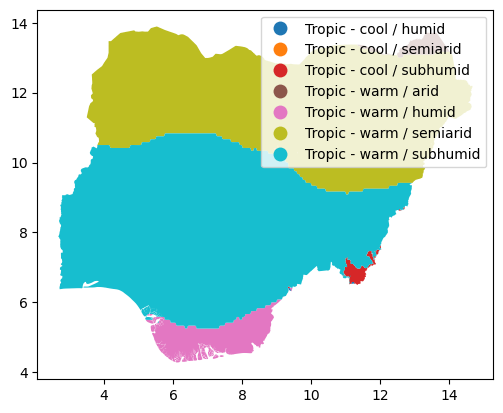

In [5]:
agroeczones.plot(column='AEZ_NAME', legend=True)

In [6]:
agroeczones.groupby('AEZ_NAME').size()

AEZ_NAME
Tropic - cool / humid        2
Tropic - cool / semiarid    11
Tropic - cool / subhumid    58
Tropic - warm / arid         1
Tropic - warm / humid        5
Tropic - warm / semiarid     1
Tropic - warm / subhumid     8
dtype: int64

### Total area by agroecological zone

In [7]:
gdf_aggregated = agroeczones.dissolve(by='AEZ_NAME')

# 2. Calculate total area for each aggregated polygon
gdf_aggregated['total_area'] = gdf_aggregated.geometry.area

# 3. Sort the aggregated polygons by total area in descending order
gdf_sorted = gdf_aggregated.sort_values(by='total_area', ascending=False)

# 4. Reset index for convenience
gdf_sorted = gdf_sorted.reset_index()

# Display the sorted GeoDataFrame
gdf_sorted

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


,AEZ_NAME,geometry,OBJECTID,ORIG_FID,Shape_Leng,Shape__Are,Shape__Len,total_area
0,Tropic - warm / subhumid,"MULTIPOLYGON (((5.55764 5.43644, 5.55764 5.435...",79,16,1.539182e+04,1.200022e+07,3.145615e+04,37.285478
1,Tropic - warm / semiarid,"POLYGON ((5.54515 13.88414, 5.58343 13.86797, ...",78,15,2.122713e+07,4.202570e+11,3.658463e+06,33.210596
2,Tropic - warm / humid,"MULTIPOLYGON (((5.46681 4.88958, 5.46681 4.889...",73,14,3.118830e+04,5.645729e+07,3.630725e+04,3.207491
3,Tropic - cool / subhumid,"MULTIPOLYGON (((9.41620 6.32340, 9.41658 6.321...",14,12,1.266280e+04,9.159550e+05,5.503706e+03,0.696230
4,Tropic - warm / arid,"MULTIPOLYGON (((11.47376 13.35702, 11.48009 13...",72,13,6.891109e+07,8.398491e+09,7.831912e+05,0.659499
5,Tropic - cool / humid,"MULTIPOLYGON (((9.41981 6.32767, 9.41717 6.326...",1,10,3.014806e+04,5.144335e+07,3.015778e+04,0.008361
6,Tropic - cool / semiarid,"MULTIPOLYGON (((13.28530 10.10808, 13.28510 10...",3,11,5.141956e+03,1.689663e+06,5.141956e+03,0.004218


## Model predictions

### Get model

In [8]:
def load_trained_model(results_path):
    preds = np.load(results_path / 'all_preds.npy')
    labels = np.load(results_path / 'all_labels.npy')
    return preds, labels

def get_trained_model_preds_and_checkpoint(model_run: int = 949):
    results_path = Path(f'../data/lightning_logs/version_{model_run}/testing')
    preds, labels = load_trained_model(results_path)
    checkpoint_path = str([path for path in (results_path.parent / 'checkpoints').glob('*')][0]) # assumes there is only one checkpoint
    return preds, labels, checkpoint_path

In [9]:
model_run = 949
preds, labels, checkpoint_path = get_trained_model_preds_and_checkpoint(model_run)
preds, labels, checkpoint_path

(array([[[0.3030314 ],
         [0.7549837 ],
         [0.20750901],
         [0.9613093 ],
         [0.82614106],
         [0.1984966 ],
         [0.98621887],
         [0.00310003],
         [0.7229861 ],
         [0.19796589],
         [0.57009614],
         [0.941696  ],
         [0.05992664],
         [0.26911053],
         [0.14679389],
         [0.9517912 ],
         [0.8031876 ],
         [0.0645072 ],
         [0.29451996],
         [0.01472747],
         [0.86969733],
         [0.02767972],
         [0.3178379 ],
         [0.36699978],
         [0.21238445],
         [0.20448738],
         [0.28634298],
         [0.99215335],
         [0.51364124],
         [0.6067583 ],
         [0.39815053],
         [0.03625782],
         [0.06981996],
         [0.9835681 ],
         [0.20640364],
         [0.22731367],
         [0.83595926],
         [0.23403536],
         [0.6765252 ],
         [0.04406602],
         [0.00389496],
         [0.13625774],
         [0.0054753 ],
         [0

### Get test set geodataframe and add model predictions

In [10]:
def get_labels_dataframe(eval_set: str = 'testing'):
    # Get subset
    labels_path = Path('../data/features/nigeria-cropharvest/labels.geojson')
    gdf = gpd.read_file(labels_path)
    assert eval_set in ['testing', 'validation']
    val_gdf = gdf[gdf['new_set'] == eval_set]
    
    # Drop missing arrays
    arrays_path = Path('../data/features/nigeria-cropharvest/features/arrays')
    existing_arrays_ids = sorted([int(str(path.stem).split('_')[0]) for path in arrays_path.glob('*.h5')])
    missing_files_identifiers = list(set(list(range(1827))) - set(existing_arrays_ids))

    # We don't consider the missing h5 files to ensure a fair comparison with the other models
    val_gdf = val_gdf.loc[~val_gdf['identifier'].isin(missing_files_identifiers)]

    return val_gdf

In [11]:
eval_set = 'testing'
gdf_preds = get_labels_dataframe(eval_set)

In [12]:
# Check that all labels are in the same order as the dataframe with labels so predictions can be appended as a column
assert all(labels.squeeze() == gdf_preds.is_crop.to_numpy()), 'labels saved from model checkpoint are not in the same order as the dataframe with labels'

In [13]:
preds

array([[[0.3030314 ],
        [0.7549837 ],
        [0.20750901],
        [0.9613093 ],
        [0.82614106],
        [0.1984966 ],
        [0.98621887],
        [0.00310003],
        [0.7229861 ],
        [0.19796589],
        [0.57009614],
        [0.941696  ],
        [0.05992664],
        [0.26911053],
        [0.14679389],
        [0.9517912 ],
        [0.8031876 ],
        [0.0645072 ],
        [0.29451996],
        [0.01472747],
        [0.86969733],
        [0.02767972],
        [0.3178379 ],
        [0.36699978],
        [0.21238445],
        [0.20448738],
        [0.28634298],
        [0.99215335],
        [0.51364124],
        [0.6067583 ],
        [0.39815053],
        [0.03625782],
        [0.06981996],
        [0.9835681 ],
        [0.20640364],
        [0.22731367],
        [0.83595926],
        [0.23403536],
        [0.6765252 ],
        [0.04406602],
        [0.00389496],
        [0.13625774],
        [0.0054753 ],
        [0.01581116],
        [0.5045086 ],
        [0

In [14]:
gdf_preds['preds'] = preds.squeeze()
gdf_preds['preds_thr0.5'] = (gdf_preds['preds'] > 0.5).astype(int)    
gdf_preds

,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,export_identifier,is_test,label,geometry,preds,preds_thr0.5
2,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,2_nigeria_2019-04-03_2020-03-28,True,None,POINT (11.67388 10.44224),0.303031,0
4,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,4_nigeria_2019-04-03_2020-03-28,True,None,POINT (7.09929 7.98053),0.754984,1
6,0,8.898685,10.414310,6,6,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,6_nigeria_2019-04-03_2020-03-28,True,None,POINT (10.41431 8.89868),0.207509,0
7,1,8.670462,5.551517,7,7,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,7_nigeria_2019-04-03_2020-03-28,True,None,POINT (5.55152 8.67046),0.961309,1
16,0,8.369347,9.376651,16,16,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,16_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.37665 8.36935),0.826141,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,0,13.160274,12.016438,1811,1811,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1811_nigeria_2019-04-03_2020-03-28,True,None,POINT (12.01644 13.16027),0.168938,0
1813,1,9.574509,9.083099,1813,1813,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1813_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.08310 9.57451),0.827862,1
1816,1,8.864097,6.457343,1816,1816,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1816_nigeria_2019-04-03_2020-03-28,True,None,POINT (6.45734 8.86410),0.780210,1
1819,0,8.261962,9.678086,1819,1819,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1819_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.67809 8.26196),0.922844,1


<AxesSubplot:>

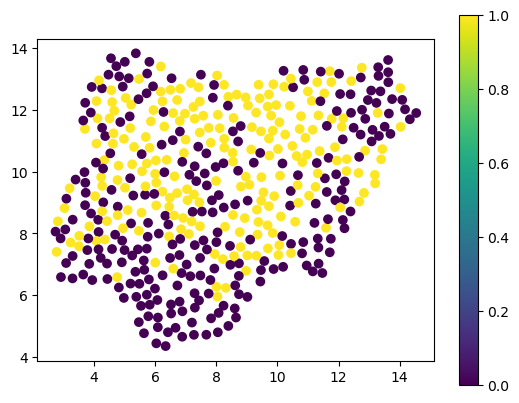

In [15]:
gdf_preds.plot(column='preds_thr0.5', legend=True)

In [16]:
gdf_preds['is_correct'] = gdf_preds['preds_thr0.5'] == gdf_preds['is_crop']
gdf_preds

,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,export_identifier,is_test,label,geometry,preds,preds_thr0.5,is_correct
2,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,2_nigeria_2019-04-03_2020-03-28,True,None,POINT (11.67388 10.44224),0.303031,0,True
4,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,4_nigeria_2019-04-03_2020-03-28,True,None,POINT (7.09929 7.98053),0.754984,1,False
6,0,8.898685,10.414310,6,6,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,6_nigeria_2019-04-03_2020-03-28,True,None,POINT (10.41431 8.89868),0.207509,0,True
7,1,8.670462,5.551517,7,7,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,7_nigeria_2019-04-03_2020-03-28,True,None,POINT (5.55152 8.67046),0.961309,1,True
16,0,8.369347,9.376651,16,16,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,16_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.37665 8.36935),0.826141,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,0,13.160274,12.016438,1811,1811,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1811_nigeria_2019-04-03_2020-03-28,True,None,POINT (12.01644 13.16027),0.168938,0,True
1813,1,9.574509,9.083099,1813,1813,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1813_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.08310 9.57451),0.827862,1,True
1816,1,8.864097,6.457343,1816,1816,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1816_nigeria_2019-04-03_2020-03-28,True,None,POINT (6.45734 8.86410),0.780210,1,True
1819,0,8.261962,9.678086,1819,1819,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1819_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.67809 8.26196),0.922844,1,False


In [17]:
gdf_preds['correct_color'] = gdf_preds['is_correct'].map({True: 'green', False: 'red'})
gdf_preds


,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,export_identifier,is_test,label,geometry,preds,preds_thr0.5,is_correct,correct_color
2,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,2_nigeria_2019-04-03_2020-03-28,True,None,POINT (11.67388 10.44224),0.303031,0,True,green
4,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,4_nigeria_2019-04-03_2020-03-28,True,None,POINT (7.09929 7.98053),0.754984,1,False,red
6,0,8.898685,10.414310,6,6,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,6_nigeria_2019-04-03_2020-03-28,True,None,POINT (10.41431 8.89868),0.207509,0,True,green
7,1,8.670462,5.551517,7,7,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,7_nigeria_2019-04-03_2020-03-28,True,None,POINT (5.55152 8.67046),0.961309,1,True,green
16,0,8.369347,9.376651,16,16,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,16_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.37665 8.36935),0.826141,1,False,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1811,0,13.160274,12.016438,1811,1811,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1811_nigeria_2019-04-03_2020-03-28,True,None,POINT (12.01644 13.16027),0.168938,0,True,green
1813,1,9.574509,9.083099,1813,1813,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1813_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.08310 9.57451),0.827862,1,True,green
1816,1,8.864097,6.457343,1816,1816,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1816_nigeria_2019-04-03_2020-03-28,True,None,POINT (6.45734 8.86410),0.780210,1,True,green
1819,0,8.261962,9.678086,1819,1819,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1819_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.67809 8.26196),0.922844,1,False,red


In [18]:
gdf_preds['is_correct'].mean()

0.8417582417582418

<AxesSubplot:>

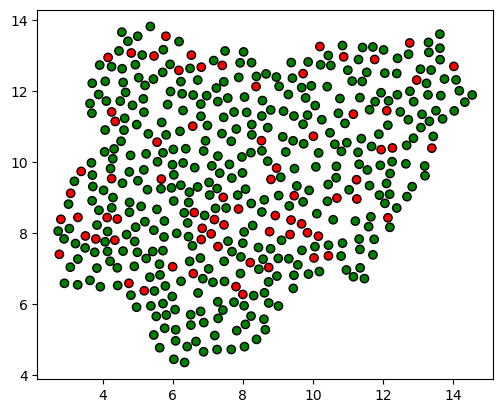

In [19]:
gdf_preds.plot(color=gdf_preds['correct_color'], legend=True, edgecolor='black')

### Get WorldCover predictions

In [20]:
# Geojson generated with notebook 22
gdf_worldcover = gpd.read_file('../results/worldcover_testing.geojson')
gdf_worldcover

,dataset,end_date,export_end_date,export_identifier,identifier,index,is_crop,is_test,lat,lon,ESApixel_value,new_set,start_date,y_pred,geometry
0,nigeria,2020-03-28,2020-03-28,2_nigeria_2019-04-03_2020-03-28,2,2,0,True,10.442239,11.673885,30,testing,2019-04-03,0,POINT (11.67388 10.44224)
1,nigeria,2020-03-28,2020-03-28,4_nigeria_2019-04-03_2020-03-28,4,4,0,True,7.980531,7.099293,20,testing,2019-04-03,0,POINT (7.09929 7.98053)
2,nigeria,2020-03-28,2020-03-28,6_nigeria_2019-04-03_2020-03-28,6,6,0,True,8.898685,10.414310,20,testing,2019-04-03,0,POINT (10.41431 8.89868)
3,nigeria,2020-03-28,2020-03-28,7_nigeria_2019-04-03_2020-03-28,7,7,1,True,8.670462,5.551517,30,testing,2019-04-03,0,POINT (5.55152 8.67046)
4,nigeria,2020-03-28,2020-03-28,16_nigeria_2019-04-03_2020-03-28,16,16,0,True,8.369347,9.376651,20,testing,2019-04-03,0,POINT (9.37665 8.36935)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,nigeria,2020-03-28,2020-03-28,1811_nigeria_2019-04-03_2020-03-28,1811,1811,0,True,13.160274,12.016438,30,testing,2019-04-03,0,POINT (12.01644 13.16027)
451,nigeria,2020-03-28,2020-03-28,1813_nigeria_2019-04-03_2020-03-28,1813,1813,1,True,9.574509,9.083099,40,testing,2019-04-03,1,POINT (9.08310 9.57451)
452,nigeria,2020-03-28,2020-03-28,1816_nigeria_2019-04-03_2020-03-28,1816,1816,1,True,8.864097,6.457343,60,testing,2019-04-03,0,POINT (6.45734 8.86410)
453,nigeria,2020-03-28,2020-03-28,1819_nigeria_2019-04-03_2020-03-28,1819,1819,0,True,8.261962,9.678086,30,testing,2019-04-03,0,POINT (9.67809 8.26196)


In [21]:
(gdf_worldcover['y_pred'] == gdf_worldcover['is_crop']).sum() / len(gdf_worldcover) # accuracy

0.8703296703296703

In [22]:
merged_predictions = gdf_preds.merge(gdf_worldcover[['identifier', 'y_pred']], on='identifier')
merged_predictions.rename(columns={'y_pred': 'preds_worldcover'}, inplace=True)
merged_predictions

,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,export_identifier,is_test,label,geometry,preds,preds_thr0.5,is_correct,correct_color,preds_worldcover
0,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,2_nigeria_2019-04-03_2020-03-28,True,None,POINT (11.67388 10.44224),0.303031,0,True,green,0
1,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,4_nigeria_2019-04-03_2020-03-28,True,None,POINT (7.09929 7.98053),0.754984,1,False,red,0
2,0,8.898685,10.414310,6,6,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,6_nigeria_2019-04-03_2020-03-28,True,None,POINT (10.41431 8.89868),0.207509,0,True,green,0
3,1,8.670462,5.551517,7,7,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,7_nigeria_2019-04-03_2020-03-28,True,None,POINT (5.55152 8.67046),0.961309,1,True,green,0
4,0,8.369347,9.376651,16,16,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,16_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.37665 8.36935),0.826141,1,False,red,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0,13.160274,12.016438,1811,1811,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1811_nigeria_2019-04-03_2020-03-28,True,None,POINT (12.01644 13.16027),0.168938,0,True,green,0
451,1,9.574509,9.083099,1813,1813,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1813_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.08310 9.57451),0.827862,1,True,green,1
452,1,8.864097,6.457343,1816,1816,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1816_nigeria_2019-04-03_2020-03-28,True,None,POINT (6.45734 8.86410),0.780210,1,True,green,0
453,0,8.261962,9.678086,1819,1819,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1819_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.67809 8.26196),0.922844,1,False,red,0


In [23]:
merged_predictions['worldcover_is_correct'] = merged_predictions['preds_worldcover'] == merged_predictions['is_crop']
merged_predictions['worldcover_correct_color'] = merged_predictions['worldcover_is_correct'].map({True: 'green', False: 'red'})
merged_predictions

,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,...,is_test,label,geometry,preds,preds_thr0.5,is_correct,correct_color,preds_worldcover,worldcover_is_correct,worldcover_correct_color
0,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (11.67388 10.44224),0.303031,0,True,green,0,True,green
1,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (7.09929 7.98053),0.754984,1,False,red,0,True,green
2,0,8.898685,10.414310,6,6,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (10.41431 8.89868),0.207509,0,True,green,0,True,green
3,1,8.670462,5.551517,7,7,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (5.55152 8.67046),0.961309,1,True,green,0,False,red
4,0,8.369347,9.376651,16,16,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (9.37665 8.36935),0.826141,1,False,red,0,True,green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0,13.160274,12.016438,1811,1811,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (12.01644 13.16027),0.168938,0,True,green,0,True,green
451,1,9.574509,9.083099,1813,1813,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (9.08310 9.57451),0.827862,1,True,green,1,True,green
452,1,8.864097,6.457343,1816,1816,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (6.45734 8.86410),0.780210,1,True,green,0,False,red
453,0,8.261962,9.678086,1819,1819,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (9.67809 8.26196),0.922844,1,False,red,0,True,green


In [24]:
merged_predictions['worldcover_is_correct'].mean() # sanity check - accuracy still the same

0.8703296703296703

## Predictions by agroecological zones

In [25]:
merged_gdf = gpd.sjoin(merged_predictions, agroeczones)
merged_gdf

,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,...,preds_worldcover,worldcover_is_correct,worldcover_correct_color,index_right,OBJECTID,AEZ_NAME,ORIG_FID,Shape_Leng,Shape__Are,Shape__Len
0,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,0,True,green,77,78,Tropic - warm / semiarid,15,2.122713e+07,4.202570e+11,3.658463e+06
5,0,9.909719,11.922697,18,18,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,0,True,green,77,78,Tropic - warm / semiarid,15,2.122713e+07,4.202570e+11,3.658463e+06
10,1,12.923484,12.414112,46,46,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,0,False,red,77,78,Tropic - warm / semiarid,15,2.122713e+07,4.202570e+11,3.658463e+06
11,1,12.099326,9.680777,48,48,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,1,True,green,77,78,Tropic - warm / semiarid,15,2.122713e+07,4.202570e+11,3.658463e+06
12,0,12.341068,13.752202,49,49,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,0,True,green,77,78,Tropic - warm / semiarid,15,2.122713e+07,4.202570e+11,3.658463e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1,13.243926,11.710648,326,326,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,0,False,red,71,72,Tropic - warm / arid,13,6.891109e+07,8.398491e+09,7.831912e+05
115,0,13.091436,13.307519,435,435,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,0,True,green,71,72,Tropic - warm / arid,13,6.891109e+07,8.398491e+09,7.831912e+05
192,0,13.604530,13.621165,744,744,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,0,True,green,71,72,Tropic - warm / arid,13,6.891109e+07,8.398491e+09,7.831912e+05
381,0,13.371610,13.297908,1513,1513,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,0,True,green,71,72,Tropic - warm / arid,13,6.891109e+07,8.398491e+09,7.831912e+05


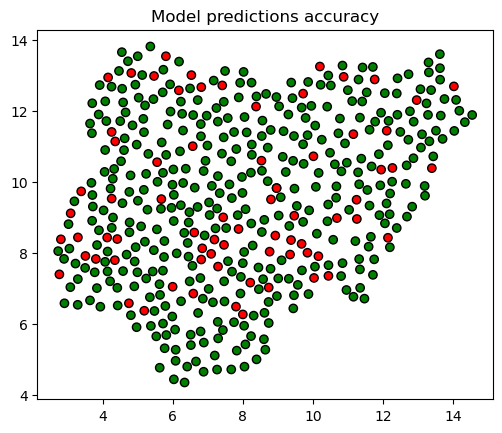

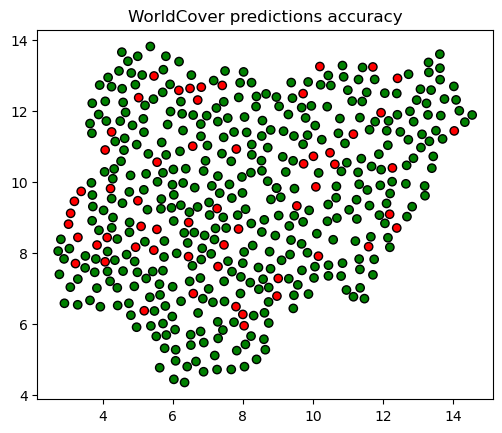

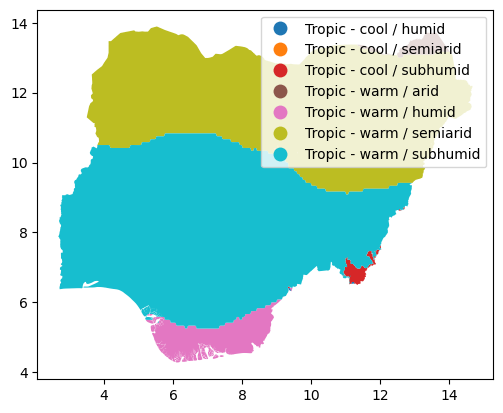

In [26]:
merged_gdf.plot(color=merged_gdf['correct_color'], legend=True, edgecolor='black')
plt.title('Model predictions accuracy')
merged_gdf.plot(color=merged_gdf['worldcover_correct_color'], legend=True, edgecolor='black')
plt.title('WorldCover predictions accuracy')
agroeczones.plot(column='AEZ_NAME', legend=True)
plt.show()

### Put figure together

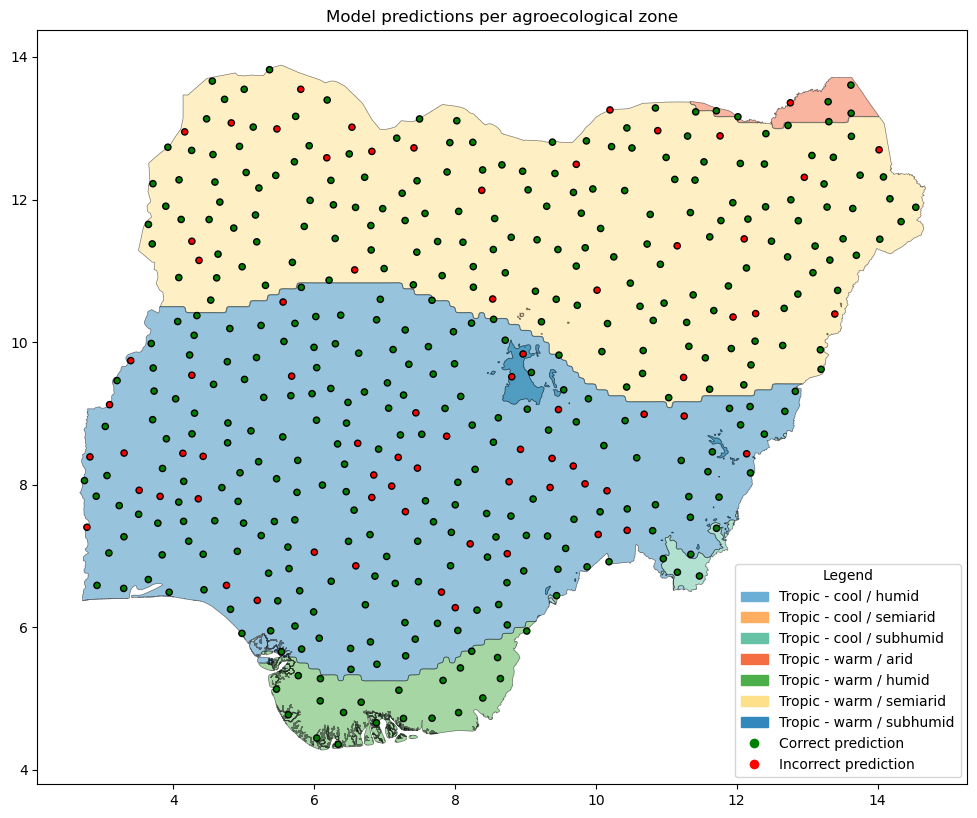

In [27]:
# Define the custom legend elements
color_mapping = {
    'Tropic - cool / humid': '#6baed6',      # Light Blue
    'Tropic - cool / semiarid': '#fdae61',   # Sandy Brown
    'Tropic - cool / subhumid': '#66c2a4',   # Light Green
    'Tropic - warm / arid': '#f46d43',       # Orange
    'Tropic - warm / humid': '#4daf4a',      # Forest Green
    'Tropic - warm / semiarid': '#fee08b',   # Golden Yellow
    'Tropic - warm / subhumid': '#3288bd'    # Teal
}

fig, ax = plt.subplots(figsize=(12, 12))
#agroeczones.plot(ax=ax, column='AEZ_NAME', linewidth=0.5, legend=True, edgecolor='black', color=color_mapping)

# Plot agroeczones with appropriate colors
for label, color in color_mapping.items():
    agroeczones[agroeczones['AEZ_NAME'] == label].plot(ax=ax, color=color, edgecolor='black', linewidth=0.5, alpha=0.5)

merged_predictions.plot(ax=ax, color=merged_predictions['correct_color'], legend=True, edgecolor='black', markersize=20)

# Create Patch objects for each agroecozone category
patches = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]

# Create Line2D objects for the points in merged_predictions
# 'correct_color' should correspond to colors for different classes in your points
unique_colors = merged_predictions['correct_color'].unique()
point_legend = [Line2D([0], [0], marker='o', color='w', label='Correct prediction', markersize=8, markerfacecolor='green'),
                Line2D([0], [0], marker='o', color='w', label='Incorrect prediction', markersize=8, markerfacecolor='red')]

# Combine the patches and point legends
legend_elements = patches + point_legend

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='lower right', title='Legend')

# Show the plot
plt.title('Model predictions per agroecological zone')
plt.show()


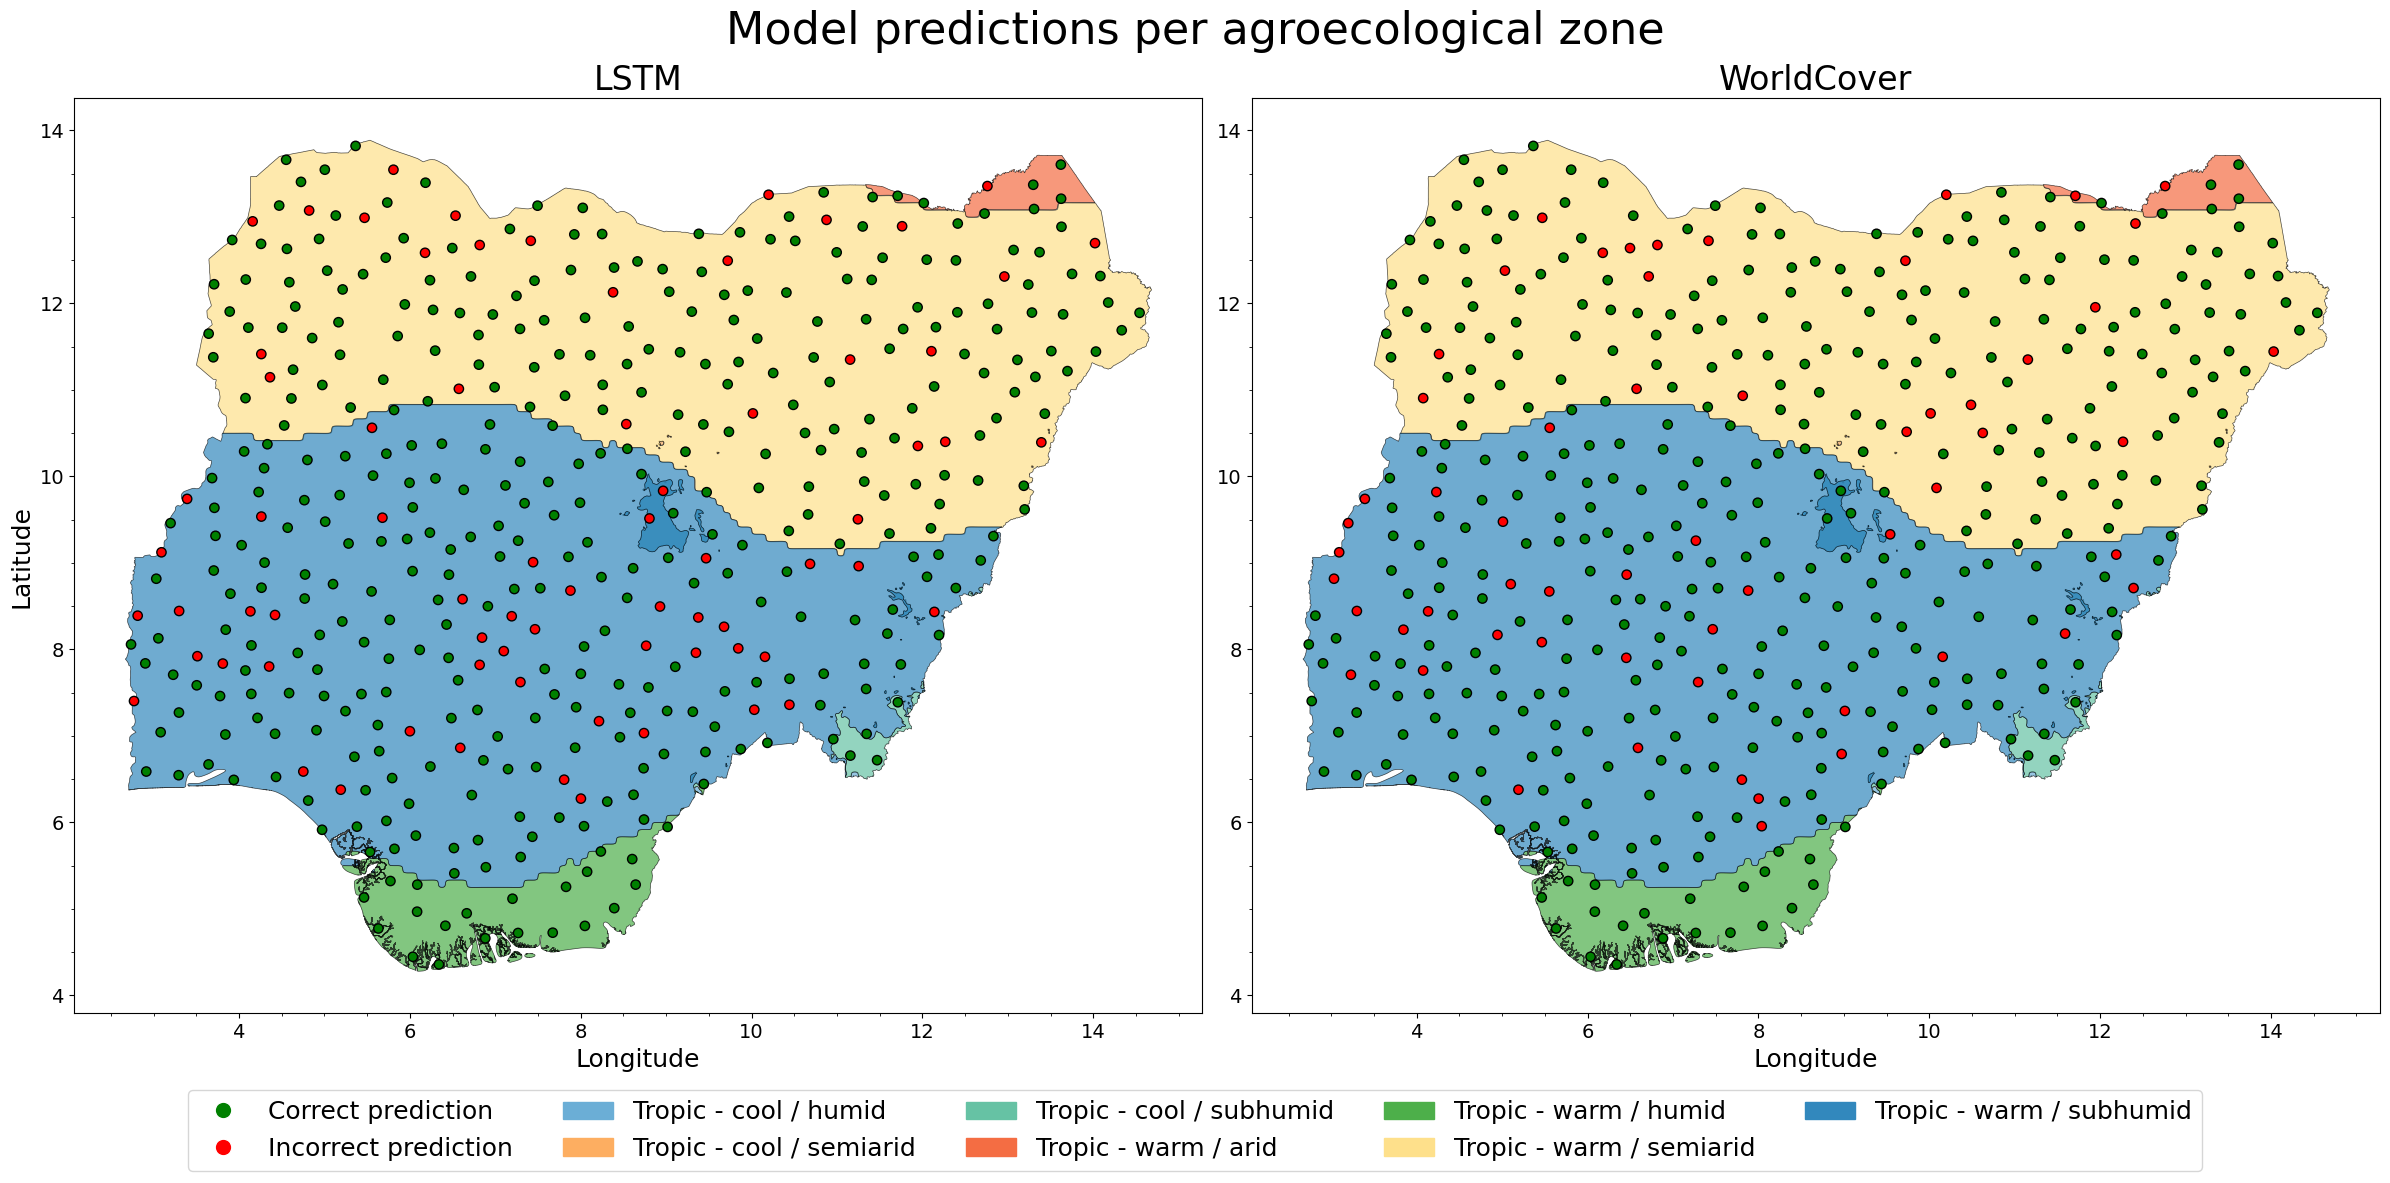

In [28]:
color_mapping = {
    'Tropic - cool / humid': '#6baed6',      # Light Blue
    'Tropic - cool / semiarid': '#fdae61',   # Sandy Brown
    'Tropic - cool / subhumid': '#66c2a4',   # Light Green
    'Tropic - warm / arid': '#f46d43',       # Orange
    'Tropic - warm / humid': '#4daf4a',      # Forest Green
    'Tropic - warm / semiarid': '#fee08b',   # Golden Yellow
    'Tropic - warm / subhumid': '#3288bd'    # Teal
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))

# Plot agroecozones in the first subplot
for label, color in color_mapping.items():
    agroeczones[agroeczones['AEZ_NAME'] == label].plot(ax=ax1, color=color, edgecolor='black', linewidth=0.5, alpha=0.7)

# Plot points from the first model
merged_predictions.plot(ax=ax1, color=merged_predictions['correct_color'], edgecolor='black', markersize=45)
ax1.set_title('LSTM', fontsize=24)
ax1.set_xlabel('Longitude', fontsize=18)
ax1.set_ylabel('Latitude', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.minorticks_on()

# Plot agroecozones in the second subplot
for label, color in color_mapping.items():
    agroeczones[agroeczones['AEZ_NAME'] == label].plot(ax=ax2, color=color, edgecolor='black', linewidth=0.5, alpha=0.7)

# Plot points from the second model
merged_predictions.plot(ax=ax2, color=merged_predictions['worldcover_correct_color'], edgecolor='black', markersize=45)
ax2.set_title('WorldCover', fontsize=24)
ax2.set_xlabel('Longitude', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.minorticks_on()

# Create Patch objects for each agroecozone category
patches = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]

# Define colors for points
unique_colors_1 = merged_predictions['correct_color'].unique()
unique_colors_2 = merged_predictions['worldcover_correct_color'].unique()

# Create Line2D objects for the points in merged_predictions

point_legend = [Line2D([0], [0], marker='o', color='w', label='Correct prediction', markersize=12, markerfacecolor='green'),
                Line2D([0], [0], marker='o', color='w', label='Incorrect prediction', markersize=12, markerfacecolor='red')]


# Combine the patches and point legends
legend_elements = point_legend + patches

# Add the legend below the plots
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=18)

# Adjust layout to make space for the legend
fig.tight_layout(rect=[0, 0.1, 1, 0.95])
fig.suptitle('Model predictions per agroecological zone', fontsize=32)

# Show the plot
fig.savefig('../figures/results_by_agrozone.pdf', bbox_inches='tight', dpi=600)
fig.savefig('../figures/results_by_agrozone.png', bbox_inches='tight', dpi=600)
plt.show()

In [25]:
#merged_gdf.to_file('../results/model_predictions_by_agroeczones.shp')  

### Summary table

In [123]:
merged_predictions

,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,...,is_test,label,geometry,preds,preds_thr0.5,is_correct,correct_color,preds_worldcover,worldcover_is_correct,worldcover_correct_color
0,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (11.67388 10.44224),0.303031,0,True,green,0,True,green
1,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (7.09929 7.98053),0.754984,1,False,red,0,True,green
2,0,8.898685,10.414310,6,6,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (10.41431 8.89868),0.207509,0,True,green,0,True,green
3,1,8.670462,5.551517,7,7,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (5.55152 8.67046),0.961309,1,True,green,0,False,red
4,0,8.369347,9.376651,16,16,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (9.37665 8.36935),0.826141,1,False,red,0,True,green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0,13.160274,12.016438,1811,1811,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (12.01644 13.16027),0.168938,0,True,green,0,True,green
451,1,9.574509,9.083099,1813,1813,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (9.08310 9.57451),0.827862,1,True,green,1,True,green
452,1,8.864097,6.457343,1816,1816,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (6.45734 8.86410),0.780210,1,True,green,0,False,red
453,0,8.261962,9.678086,1819,1819,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,...,True,None,POINT (9.67809 8.26196),0.922844,1,False,red,0,True,green


In [169]:
agroeczones = agroeczones.to_crs(epsg=32633)  # Example EPSG, replace with appropriate one for your data
agroeczones['area'] = agroeczones['geometry'].area / 1e6  # Convert area to square kilometers
agroeczones = agroeczones.to_crs(epsg=4326)  # Example EPSG, replace with appropriate one for your data

merged_gdf = gpd.sjoin(merged_predictions, agroeczones)

grouped = merged_gdf.groupby('AEZ_NAME').agg(
    total_points=('identifier', 'count'),
    lstm_accuracy=('is_correct', lambda x: (x == True).sum() / x.count()),
    worldcover_accuracy=('worldcover_is_correct', lambda x: (x == True).sum() / x.count()),
    #area=('area', lambda x: x.sum() / 1e6),
).reset_index().sort_values(by='total_points', ascending=False)

grouped

,AEZ_NAME,total_points,lstm_accuracy,worldcover_accuracy
4,Tropic - warm / subhumid,232,0.806034,0.853448
3,Tropic - warm / semiarid,191,0.863874,0.879581
2,Tropic - warm / humid,19,1.000000,1.000000
1,Tropic - warm / arid,5,1.000000,0.800000
0,Tropic - cool / subhumid,4,0.750000,1.000000


In [170]:
agroeczones.area.sum()

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


75.40968912619954

In [171]:
agroeczones_area = agroeczones.groupby('AEZ_NAME').agg({'Shape__Are': 'sum'}).reset_index()
agroeczones_area

,AEZ_NAME,Shape__Are
0,Tropic - cool / humid,1.042722e+08
1,Tropic - cool / semiarid,5.313886e+07
2,Tropic - cool / subhumid,8.712347e+09
3,Tropic - warm / arid,8.398491e+09
4,Tropic - warm / humid,3.990182e+10
5,Tropic - warm / semiarid,4.202570e+11
6,Tropic - warm / subhumid,4.626342e+11


In [172]:
summary_df = pd.merge(grouped, agroeczones_area, on='AEZ_NAME')
summary_df

,AEZ_NAME,total_points,lstm_accuracy,worldcover_accuracy,Shape__Are
0,Tropic - warm / subhumid,232,0.806034,0.853448,4.626342e+11
1,Tropic - warm / semiarid,191,0.863874,0.879581,4.202570e+11
2,Tropic - warm / humid,19,1.000000,1.000000,3.990182e+10
3,Tropic - warm / arid,5,1.000000,0.800000,8.398491e+09
4,Tropic - cool / subhumid,4,0.750000,1.000000,8.712347e+09


In [173]:
summary_df.rename(columns={'Shape__Are': 'total_area_km2'}, inplace=True)

In [174]:
summary_df['total_area_km2'] = summary_df['total_area_km2'] / 1e6

In [178]:
summary_df.round(3)

,AEZ_NAME,total_points,lstm_accuracy,worldcover_accuracy,total_area_km2
0,Tropic - warm / subhumid,232,0.806,0.853,462634.188
1,Tropic - warm / semiarid,191,0.864,0.880,420257.006
2,Tropic - warm / humid,19,1.000,1.000,39901.816
3,Tropic - warm / arid,5,1.000,0.800,8398.491
4,Tropic - cool / subhumid,4,0.750,1.000,8712.347


In [176]:
summary_df['total_area_km2'].sum() # too much by about 16'000 km2, but good enough for a rough estimate

939903.8476780459

In [ ]:
summary_